In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from agrid.grid import Grid
from pathlib import Path
import os, sys, pickle

from pathlib import Path

import pandas as pd

import re
import copy

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

from scipy import stats, interpolate, spatial, io
from scipy.ndimage import gaussian_filter, median_filter
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import Arc 
import cartopy.crs as ccrs

import pyproj as proj
import rasterio


from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing
import numba as nb
from numba import jit

import warnings
warnings.filterwarnings('ignore')

# helper function for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance

from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer , r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance

from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance

import seaborn as sns

from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import gstools as gst
from pykrige.rk import RegressionKriging
import operator


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance

import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from pykrige.rk import Krige
from sklearn.model_selection import KFold

from skgstat import Variogram


from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder , PowerTransformer

from sklearn.compose import TransformedTargetRegressor ,  ColumnTransformer


from sklearn.compose import make_column_selector as selector

from sklearn.model_selection import cross_val_score

In [3]:
dir_p = Path().resolve() 

#constants
km = 1000
milli = 0.001
micro = 0.000001

# fig size for presentation
fig_pres_small = (4,3)

fig_pres_small_cbar = (4,2)
#aspect ratio
fig_pres_large = (16,9)

src_crs=4326
src_crs_aus = 3577


# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  


# create grid for each region
# crs Coordinate reference system

#EPSG is projection
# 0.2 degrees equal roughly 20 km

World = Grid(res=[0.2, 0.2], up=world_lat_max, down=world_lat_min)

# africa grid

Africa =    Grid(res=[0.2, 0.2],  left = afr_lon_min, right= afr_lon_max, up=afr_lat_max , down=afr_lat_min)

# africa grid low resolution 50 x 50 km

Africa_50 =    Grid(res=[0.5, 0.5],  left = afr_lon_min, right= afr_lon_max, up=afr_lat_max , down=afr_lat_min)



#dictionary of all grids

grids = {}

grids['Afr'] = Africa
grids['Afr_50'] = Africa_50
grids['World'] = World


In [4]:

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [5]:
# to ease looping with dictionaries

regions_a_a5 = [ 'Afr','Afr_50' ]

regions_w_a = [ 'World' ,'Afr',]


regions_w_a_a5 = [ 'World' ,'Afr', 'Afr_50']


regions_Total = ['World' ,'Afr', 'Afr_50',]

# raster exenets to adjust map
raster_extent_Afr = [grids['Afr'].extent[0], grids['Afr'].extent[1], grids['Afr'].extent[3], grids['Afr'].extent[2]]
raster_extent_Afr_50 = [grids['Afr_50'].extent[0], grids['Afr_50'].extent[1], grids['Afr_50'].extent[3], grids['Afr_50'].extent[2]]
raster_extent_World = [grids['World'].extent[0], grids['World'].extent[1], grids['World'].extent[3], grids['World'].extent[2]]

# to correct plot maps
raster_extents = {}

raster_extents['Afr'] = raster_extent_Afr
raster_extents['Afr_50'] = raster_extent_Afr_50
raster_extents['World'] = raster_extent_World


# list of latitudes and longitudes
lon_dict = {}
lat_dict = {}

lon_dict['Afr'] = [afr_lon_min, afr_lon_max]
lon_dict['Afr_50'] = [afr_lon_min, afr_lon_max]
lon_dict['World'] = [world_lon_min, world_lon_max]

lat_dict['Afr'] = [afr_lat_min, afr_lat_max]
lat_dict['Afr_50'] = [afr_lat_min, afr_lat_max]
lat_dict['World'] = [world_lat_min, world_lat_max]


print('terminated')

terminated


In [6]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    
    y_true = y_true.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

In [7]:
obs = pd.DataFrame()


''' 
obs['REF_n'] = [ 'MOHO','LAB', 'RHO_C', 'SV', 'PV', 'CTD',
             'RHO_L', 'DEM', 
                'VOLC_DIST_W', 'A_MEDIAN_W', 'FA', 'SI','LITH_MANTLE', 
                'EMAG2_CLASS', 'GEOID', 'BG',
              'GLIM']'''



obs['OBS_REF_IDW'] = ['CTD_IDW' ,  'SI_IDW',"LAB_IDW", "MOHO_IDW",
            "SV_IDW","PV_IDW", 
            'GEOID_IDW','FA_IDW','DEM','BG_IDW', 'EMAG2_CLASS',
                   'RHO_L_IDW', 'RHO_C_IDW', 
                  'VOLC_DIST_W', 'REG', 'GLIM']



obs['OBS_REF_LN'] = ['CTD_LN' ,  'SI_LN',"LAB_LN", "MOHO_LN",
            "SV_LN","PV_LN", 
            'GEOID_LN','FA_LN','DEM','BG_LN', 'EMAG2_CLASS',
                  'RHO_L_LN', 'RHO_C_LN', 
                      'VOLC_DIST_W', 'REG', 'GLIM']
  
     
# Labels for plots etc
obs['LABELS'] = ['CTD',  'Shape index', 'LAB depth', 'Moho depth', 
                'S$_V$ 150km', 'P$_V$ 150km', 
                'Geoid', 'Free air', 'DEM', 'Bouguer', 'Mag.', 
                'Lith. ρ', 'Crust ρ',  
                 'Volcano d.', 'GliM', 'REG', ]  
    
    
# 'vp/vs'
# Units to display in plots etc
obs['UNITS'] = ['km',  'si', 'km', 'km',
             '$\delta$ v_s %','$\delta$ v_p %', 
             'm', 'mGal', 'm', 'mGal',  'f(nT)', 
                 'kg/m$^3$', 'kg/m$^3$',
                'km',  'class', 'class']
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs['V_RANGE'] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,15),]
    


#new_index = [4,3,15,6,7,0,14,10,16,17,9, 2,1,5,13,12, 8,11,]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

#obs = obs.reindex(new_index)

obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 12
print(obs)

n_obs = len(obs)

obs_dict = obs.to_dict(orient='records')



    OBS_REF_IDW   OBS_REF_LN       LABELS        UNITS      V_RANGE
0       CTD_IDW       CTD_LN          CTD           km      (0, 50)
1        SI_IDW        SI_LN  Shape index           si      (-1, 1)
2       LAB_IDW       LAB_LN    LAB depth           km     (0, 300)
3      MOHO_IDW      MOHO_LN   Moho depth           km     (15, 60)
4        SV_IDW        SV_LN  S$_V$ 150km  $\delta$...  (-0.075,...
5        PV_IDW        PV_LN  P$_V$ 150km  $\delta$...  (-0.02, ...
6     GEOID_IDW     GEOID_LN        Geoid            m    (-45, 45)
7        FA_IDW        FA_LN     Free air         mGal  (-100, 100)
8           DEM          DEM          DEM            m  (-2200, ...
9        BG_IDW        BG_LN      Bouguer         mGal  (-100, 100)
10  EMAG2_CLASS  EMAG2_CLASS         Mag.        f(nT)  (-0.4, 0.4)
11    RHO_L_IDW     RHO_L_LN      Lith. ρ     kg/m$^3$  (3260, 3...
12    RHO_C_IDW     RHO_C_LN      Crust ρ     kg/m$^3$  (2650, 2...
13  VOLC_DIST_W  VOLC_DIST_W   Volcano d.       

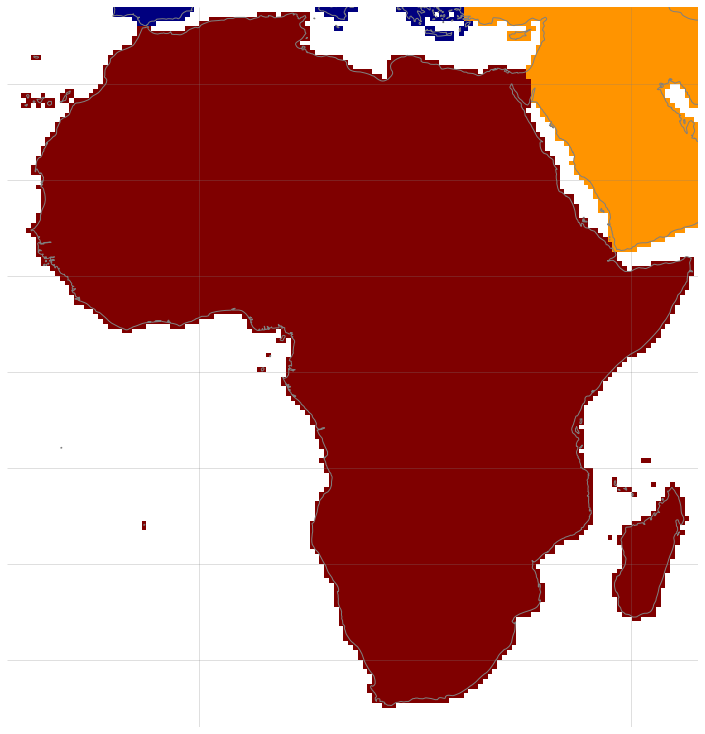

In [8]:
#https://github.com/nvkelso/natural-earth-vector
# natural earth 10 m land shape
ne_10m_land = dir_p / 'data'/ 'Shapefiles'/'NE'/ 'ne_10m_land.shp'
continents = dir_p /'data'/ 'Shapefiles'/'continents'/ 'continent.shp'

# LAND is water vs land
#Continet describes each continent

#assign_shape Rasterize vector polygons to grid 

region = 'Afr_50'
# Use continental plates instead
grids[region].ds['LAND'] = (('Y', 'X'), grids[region].assign_shape(ne_10m_land, 
                                           'scalerank', map_to_int = False, burn_val = 1))


grids[region].ds['CONTINENT'] = (('Y', 'X'), grids[region].assign_shape(continents, 
                                           'CONTINENT', map_to_int = True))



grids[region].map_grid('CONTINENT', raster_extent= raster_extents[region], 
                      cmap='jet', figsize=(10,10))

    


In [9]:
    
region = 'Afr_50'
files = [filename for filename in os.listdir(dir_p/'Grids'/'inputs') if filename.startswith(f"{region}")]
labels = [ filename.replace(f'{region}_', '').replace('.nc', '')  for filename in files]
for label, file in zip(labels,files):
    path = dir_p/'Grids'/'inputs'/f'{file}'
    grids[region].ds[f'{label}'] = (('Y', 'X'), grids[region].read_raster(path , src_crs=src_crs))


print('terminated')



terminated


In [10]:

target = 'heat-flow (mW/m2)'
coord = ['lon', 'lat']



features_ex_idw = []
#features_ex_ln = []


features_idw = obs['OBS_REF_IDW'].tolist()
#features_ln = obs['OBS_REF_LN'].tolist()


#in_features_idw = set(features_idw)
#in_features_ln = set(features_ln)

#in_features_ln_but_not_in_features_idw = in_features_ln - in_features_idw

#features_all = features_idw + list(in_features_ln_but_not_in_features_idw)


features_ex_idw = copy.deepcopy(features_idw)
features_ex_idw.extend(coord)
features_ex_idw.append(target)



#features_ex_ln = copy.deepcopy(features_ln)
#features_ex_ln.extend(coord)
#features_ex_ln.append(target)

In [14]:
train_Afr_50

,lon,lat,heat-flow (mW/m2),grid_index,dist_from_grid,VOLC_DIST,VOLC_DIST_W,LAND,CONTINENT,SV_LN,...,GEOID_IDW,FA_LN,FA_IDW,BG_LN,BG_IDW,DEM,EMAG2,EMAG2_CLASS,GLIM,REG
0,35.597,31.628,197.7,19694,27735.92...,87.755480,0.122445,1.0,1.0,-0.038098,...,19.358745,40.638942,30.822073,-22.729496,-18.565121,377,-6.057592,-0.015030,6,4
1,35.013,27.470,197.0,18541,13769.59...,237.216431,0.000000,NaN,NaN,-0.016132,...,14.163053,-25.797203,4.684617,12.289937,8.598367,-1000,-35.713905,-0.085521,15,4
2,35.622,31.600,195.5,19694,27591.18...,87.755480,0.122445,1.0,1.0,-0.038098,...,19.358745,40.638942,30.822073,-22.729496,-18.565121,377,-6.057592,-0.015030,6,4
3,34.327,27.148,195.0,18396,25170.31...,292.591277,0.000000,1.0,7.0,-0.006436,...,13.710368,-23.961527,-0.106304,19.036479,14.437374,-772,-98.299477,-0.219737,15,4
4,35.315,26.800,195.0,18398,15637.39...,195.343348,0.000000,NaN,NaN,-0.018007,...,13.076449,-10.389784,-5.128507,30.671573,10.351841,-1019,-13.654252,-0.033566,15,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,36.783,-1.300,6.0,10337,13168.21...,60.822638,0.391774,1.0,7.0,-0.023911,...,-15.778039,29.186296,16.802251,-152.801144,-150.945021,1813,-11.376120,-0.028043,10,5
2092,32.950,34.650,5.0,20553,20729.99...,360.444204,0.000000,NaN,NaN,0.038741,...,20.067373,110.347115,45.244764,147.569102,120.634189,-2702,64.244576,0.148947,15,1
2093,36.630,-1.120,4.0,10336,30834.78...,12.847217,0.871528,1.0,7.0,-0.022396,...,-15.110605,35.789976,8.447916,-176.992986,-175.277120,1437,7.179317,0.017789,10,5
2094,34.720,-0.480,3.0,10621,30768.71...,44.618883,0.553811,1.0,7.0,-0.006243,...,-15.275934,-15.180139,-7.787794,-189.678381,-175.763190,397,-0.889723,-0.002222,11,2


# best fit world

In [15]:


rating = 'rabc'
outlier = 'NOD'

file_label = f'{outlier}_{rating}'


train_Afr_50_f =  dir_p/'data'/'dataset'/'Preprocessed'/f'Training_Afr_50_{file_label}.csv'
train_Afr_50 = pd.read_csv(train_Afr_50_f)


train_Afr_50['GLIM']  = train_Afr_50['GLIM'].astype('int').astype('category')
train_Afr_50['REG']  = train_Afr_50['REG'].astype('int').astype('category')



X_train_afr = train_Afr_50[features_idw]
y_train_afr = train_Afr_50[target].values.reshape(-1,1) 



X_train_afr.describe(include='all')


bs_rfr_hyp =  dir_p/'RF_Hyperparameters'/f'RFR_{outlier}_IDW_rab.csv'



bs_rfr_hyp_df = pd.read_csv(bs_rfr_hyp, sep='\t')


best_params = bs_rfr_hyp_df.to_dict('list')

print(file_label)

X_train_afr.describe(include='all')

NOD_rabc


,CTD_IDW,SI_IDW,LAB_IDW,MOHO_IDW,SV_IDW,PV_IDW,GEOID_IDW,FA_IDW,DEM,BG_IDW,EMAG2_CLASS,RHO_L_IDW,RHO_C_IDW,VOLC_DIST_W,REG,GLIM
count,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.0,2096.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,12.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,668.0,600.0
mean,28.873403,0.085824,112.962947,33.136860,0.010383,-0.000283,19.333964,8.776164,274.841126,-20.996873,-0.004800,3309.924272,2781.883819,0.073395,NaN,NaN
std,6.403659,0.455924,37.020395,4.459684,0.033453,0.006581,17.313098,25.438247,644.527639,63.930587,0.166326,31.404974,40.729311,0.188463,NaN,NaN
min,17.313495,-0.961420,63.484222,19.699560,-0.075006,-0.019701,-37.404268,-56.312141,-2702.000000,-187.715387,-1.000000,3256.907565,2699.213576,0.000000,NaN,NaN
25%,24.386032,-0.258974,78.686867,30.562455,-0.021168,-0.004731,8.704342,-11.246346,-35.000000,-59.021393,-0.085484,3275.751090,2749.557675,0.000000,NaN,NaN
50%,26.764925,0.145277,100.198944,32.208549,0.011535,-0.001282,19.195511,9.436349,170.000000,-7.835304,0.012064,3309.640943,2779.292533,0.000000,NaN,NaN
75%,31.220102,0.424391,152.762583,35.499282,0.039440,0.004497,30.153741,25.498746,562.000000,15.001272,0.089186,3341.627260,2810.500061,0.000000,NaN,NaN


# Pre-evalaution

In [16]:
kfold = 10 
cv = KFold(n_splits=kfold, random_state=None, shuffle=True)

KPI_Afr_50 = pd.DataFrame()
results_W = pd.DataFrame()

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) * -1


#scoring = make_scorer(nrmse , greater_is_better=False )
nrmse_score = make_scorer(nrmse , greater_is_better=False)




for best_features in range(8,16):  
    regressor = RandomForestRegressor()

    tuned_params = {item[11:]: best_params[item][0] for item in best_params}
    regressor.set_params(**tuned_params)

    rfe = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("reducer", rfe),   ("regressor", regressor)]

    
    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)

    model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)



    model_pipeline.fit(X_train_afr, y_train_afr)

    
    y_predict = model_pipeline.predict(X_train_afr)
    

    KPI_Afr_50.loc['NRMSE', f'RFE_{best_features}'] = nrmse(y_train_afr, y_predict) *-1
    KPI_Afr_50.loc['RMSE', f'RFE_{best_features}'] =mean_squared_error(y_train_afr, y_predict, squared=False) 
    KPI_Afr_50.loc['MAE', f'RFE_{best_features}'] = mean_absolute_error(y_train_afr, y_predict)  
    KPI_Afr_50.loc['MAPE', f'RFE_{best_features}'] = mean_absolute_percentage_error(y_train_afr, y_predict) 
    KPI_Afr_50.loc['CD', f'RFE_{best_features}'] = r2_score(y_train_afr, y_predict)
    KPI_Afr_50.loc['EV', f'RFE_{best_features}'] = explained_variance_score(y_train_afr, y_predict)
    KPI_Afr_50.loc['CCC', f'RFE_{best_features}'] = concordance_correlation_coefficient(y_train_afr, y_predict)
    KPI_Afr_50.loc['MAX', f'RFE_{best_features}'] = y_predict.max()
    KPI_Afr_50.loc['MIN', f'RFE_{best_features}'] = y_predict.min()
    
    KPI_Afr_50.loc['MAX_E',  f'RFE_{best_features}'] = round( max_error(y_train_afr, y_predict), 3)
    KPI_Afr_50.loc['MedAE',  f'RFE_{best_features}'] = round( median_absolute_error(y_train_afr, y_predict), 3) 
    KPI_Afr_50.loc['MPE',  f'RFE_{best_features}'] = round(np.mean((y_train_afr -y_predict)/y_train_afr) , 3)
    KPI_Afr_50.loc['ACC',  f'RFE_{best_features}'] = round(100 - mean_absolute_percentage_error(y_train_afr, y_predict) *100, 3)
    KPI_Afr_50.loc['Mean',  f'RFE_{best_features}'] = round(np.mean(y_predict),3)
    KPI_Afr_50.loc['Median',  f'RFE_{best_features}'] = round(np.median(y_predict),3)
    KPI_Afr_50.loc['Stdev',  f'RFE_{best_features}'] = round(np.std(y_predict),3)
    KPI_Afr_50.loc['RSD',  f'RFE_{best_features}'] = round(np.std(y_predict) / np.mean(y_predict) ,3)
    
       
  

    
    results_W[f'RFE_{best_features}'] =y_predict.reshape(-1,)
    # Print message to user
    print('#'*60)



best_features = 16


scaler = PowerTransformer(method='yeo-johnson',standardize=True)


numeric_transformer = scaler

categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


preprocessor = ColumnTransformer(
    transformers=[
   ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
steps=[("preprocessor", preprocessor), ("reducer", rfe), ("regressor", regressor)]


# Initialize Pipeline object
pipeline= Pipeline(steps = steps)

model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)

model_pipeline.fit(X_train_afr, y_train_afr)


y_predict = model_pipeline.predict(X_train_afr)


KPI_Afr_50.loc['NRMSE', f'RFE_{best_features}'] = nrmse(y_train_afr, y_predict) *-1
KPI_Afr_50.loc['RMSE', f'RFE_{best_features}'] =mean_squared_error(y_train_afr, y_predict, squared=False) 
KPI_Afr_50.loc['MAE', f'RFE_{best_features}'] = mean_absolute_error(y_train_afr, y_predict)  
KPI_Afr_50.loc['MAPE', f'RFE_{best_features}'] = mean_absolute_percentage_error(y_train_afr, y_predict) 
KPI_Afr_50.loc['CD', f'RFE_{best_features}'] = r2_score(y_train_afr, y_predict)
KPI_Afr_50.loc['EV', f'RFE_{best_features}'] = explained_variance_score(y_train_afr, y_predict)
KPI_Afr_50.loc['CCC', f'RFE_{best_features}'] = concordance_correlation_coefficient(y_train_afr, y_predict)
KPI_Afr_50.loc['MAX', f'RFE_{best_features}'] = y_predict.max()
KPI_Afr_50.loc['MIN', f'RFE_{best_features}'] = y_predict.min()

KPI_Afr_50.loc['MAX_E',  f'RFE_{best_features}'] = round( max_error(y_train_afr, y_predict), 3)
KPI_Afr_50.loc['MedAE',  f'RFE_{best_features}'] = round( median_absolute_error(y_train_afr, y_predict), 3) 
KPI_Afr_50.loc['MPE',  f'RFE_{best_features}'] = round(np.mean((y_train_afr -y_predict)/y_train_afr) , 3)
KPI_Afr_50.loc['ACC',  f'RFE_{best_features}'] = round(100 - mean_absolute_percentage_error(y_train_afr, y_predict) *100, 3)
KPI_Afr_50.loc['Mean',  f'RFE_{best_features}'] = round(np.mean(y_predict),3)
KPI_Afr_50.loc['Median',  f'RFE_{best_features}'] = round(np.median(y_predict),3)
KPI_Afr_50.loc['Stdev',  f'RFE_{best_features}'] = round(np.std(y_predict),3)
KPI_Afr_50.loc['RSD',  f'RFE_{best_features}'] = round(np.std(y_predict) / np.mean(y_predict) ,3)





results_W[f'RFE_{best_features}'] =y_predict.reshape(-1,)
# Print message to user
print('#'*60)



Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
############################################################
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
############################################################
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
############################################################
Fitting estimator with 16 features.
Fitting estimator with 15 

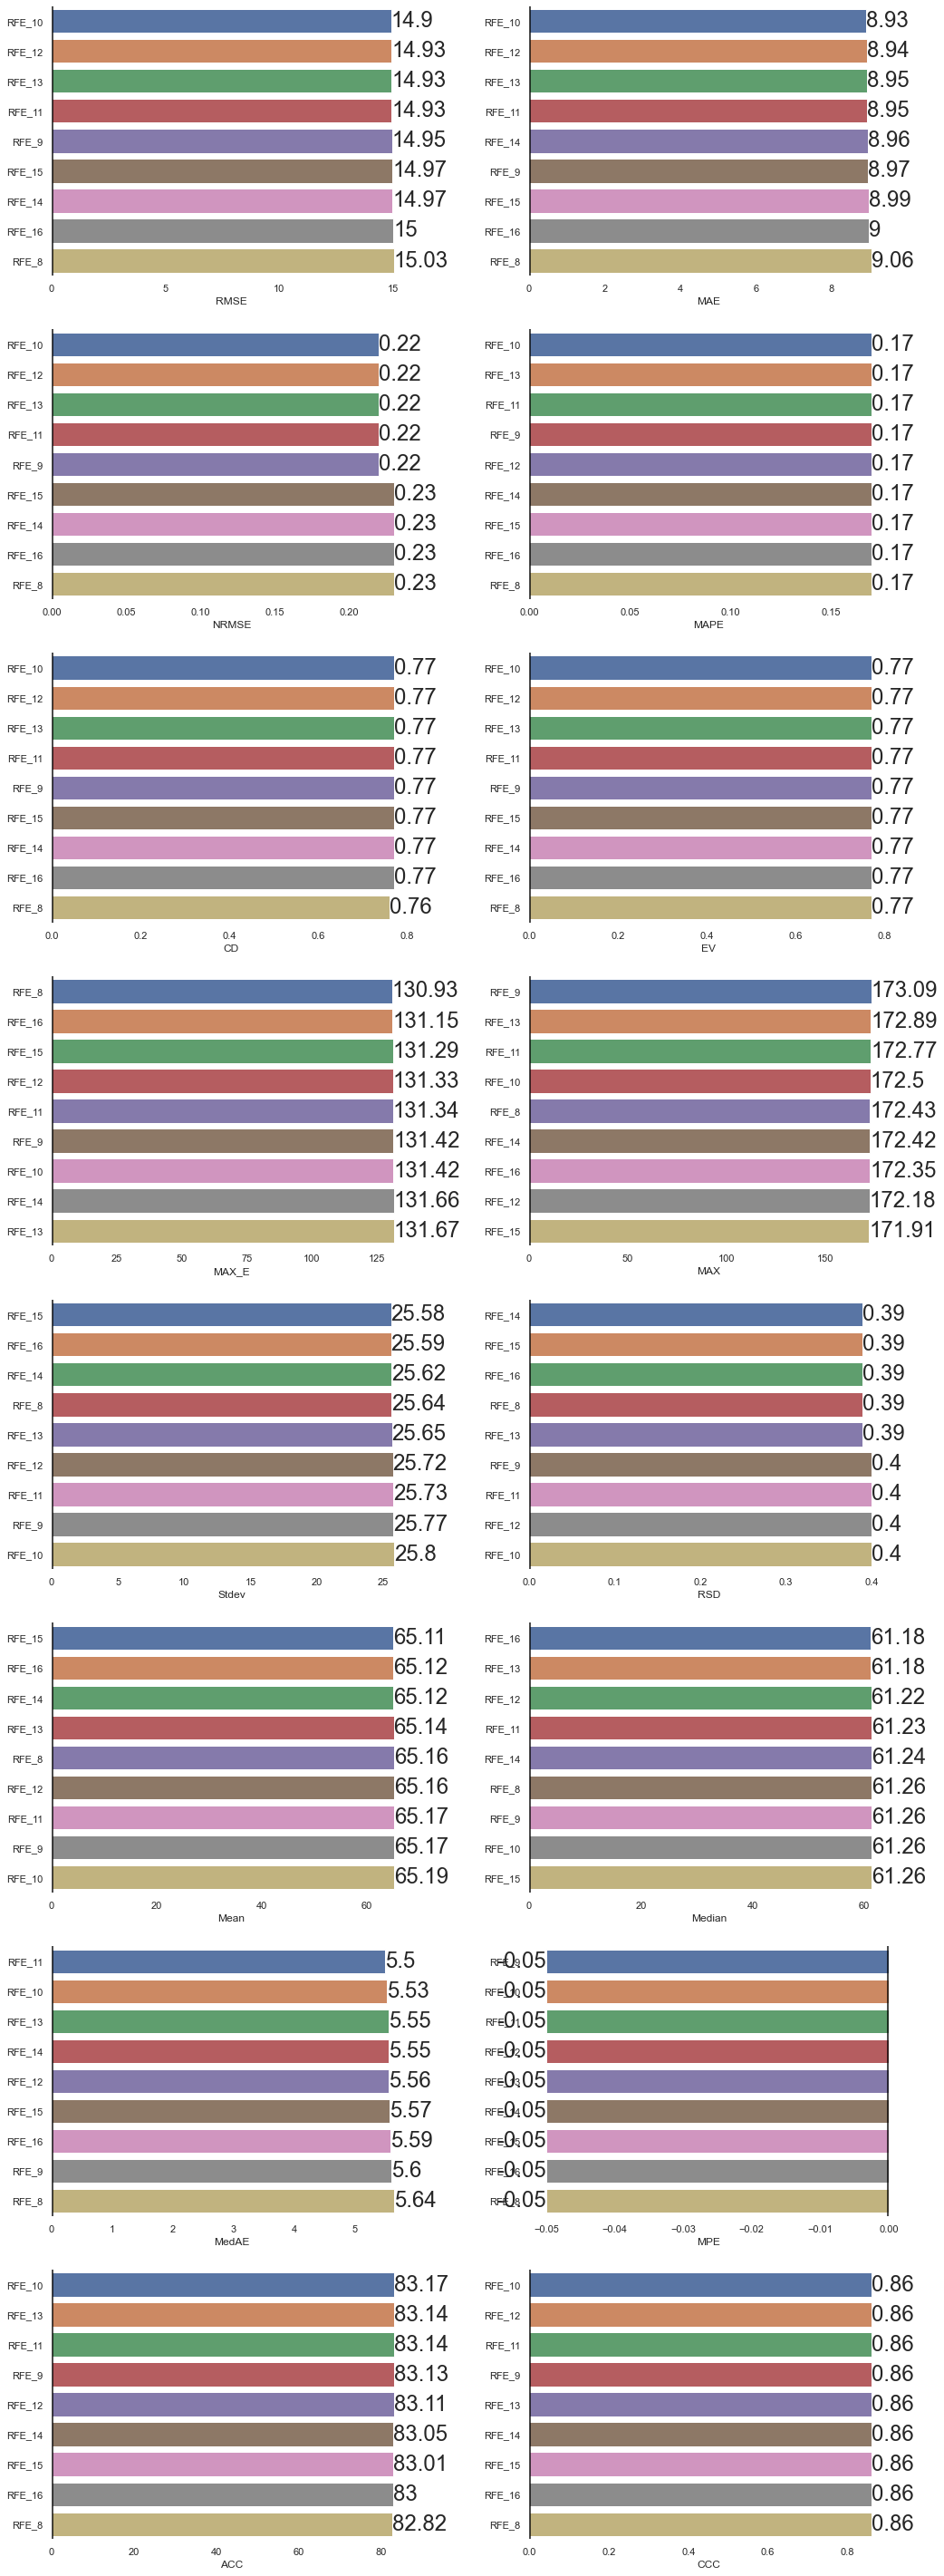

In [17]:


# Initialize auc_score dictionary

# Set figure size and create barplot

fig, axs = plt.subplots(8,2,figsize=(15, 40))

sns.set(style="whitegrid", color_codes=True, font_scale = 2)
#fig.set_size_inches(30,30)

#scores = ['RMSE', 'NRMSE','MAE', 'MAPE', 'CD','EV', 'MAX_E','MIN_E' ,'MedAE', 'MPE']

scores = ['RMSE', 'MAE', 'NRMSE','MAPE', 'CD','EV', 'MAX_E', 'MAX', 
          'Stdev', 'RSD', 'Mean','Median','MedAE', 'MPE', 'ACC', 'CCC']

# Set graph style
sns.set(font_scale = 2)
n_models = 30
#subfile = 'HOD'
#files_rg = [ x for x in files_rg if subfile in x ]
for score, ax in zip(scores, axs.flatten()):




    
    cols  = KPI_Afr_50.loc[score,:].sort_values(ascending=False).index.tolist()


    if score in ['CD','EV' ,'MAX', 'MPE', 'ACC','CCC']:
        
        
        x_data = KPI_Afr_50.loc[score,cols].sort_values(ascending=False).index
        y_data = KPI_Afr_50.loc[score,cols].sort_values(ascending=False).round(2)
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0])

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()
    else:
        x_data = KPI_Afr_50.loc[score,cols].sort_values().index
        y_data = KPI_Afr_50.loc[score,cols].sort_values().round(2)
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0], )

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()



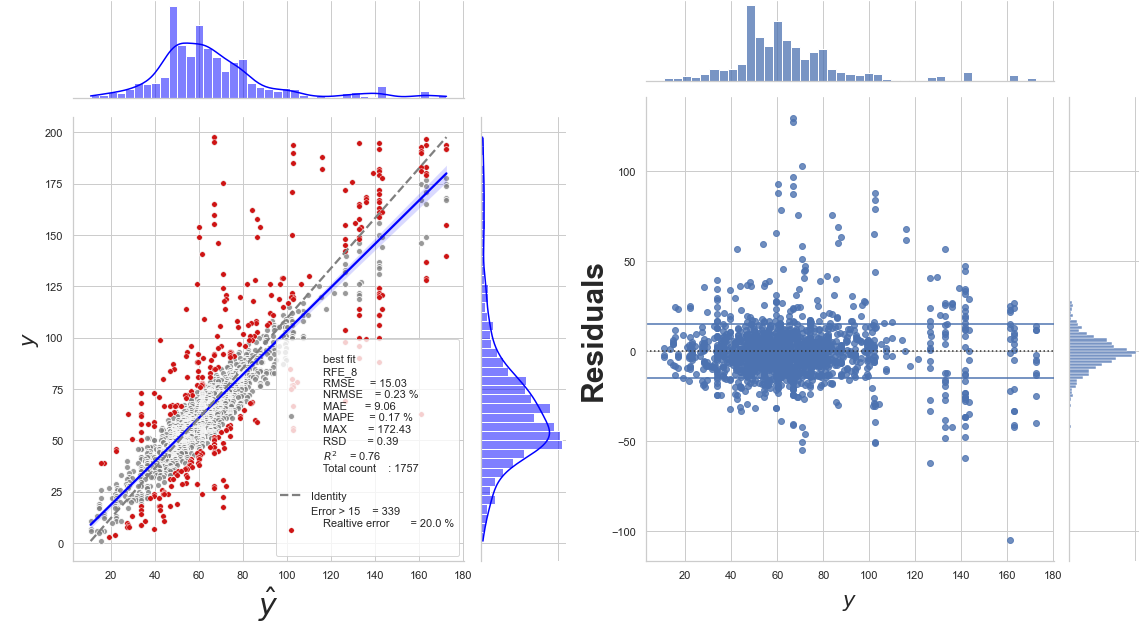

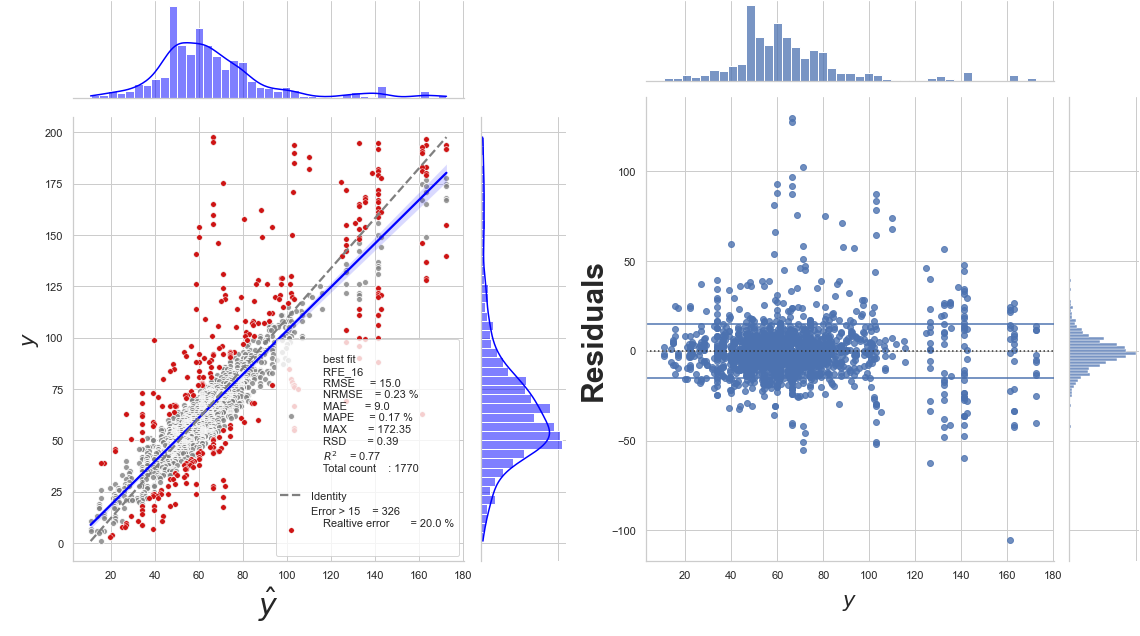

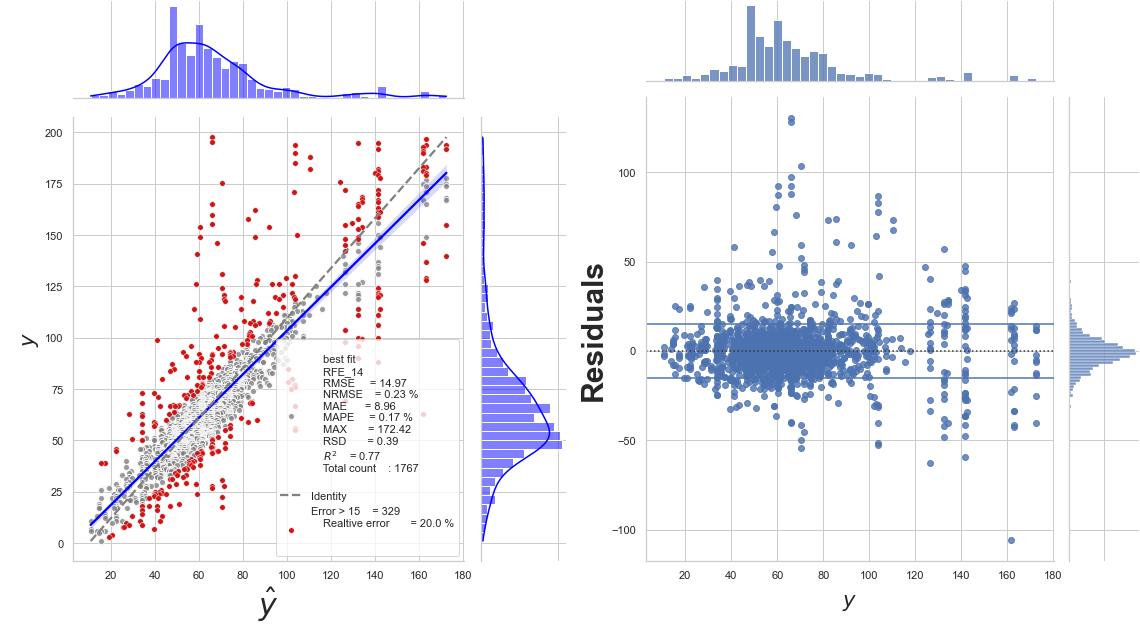

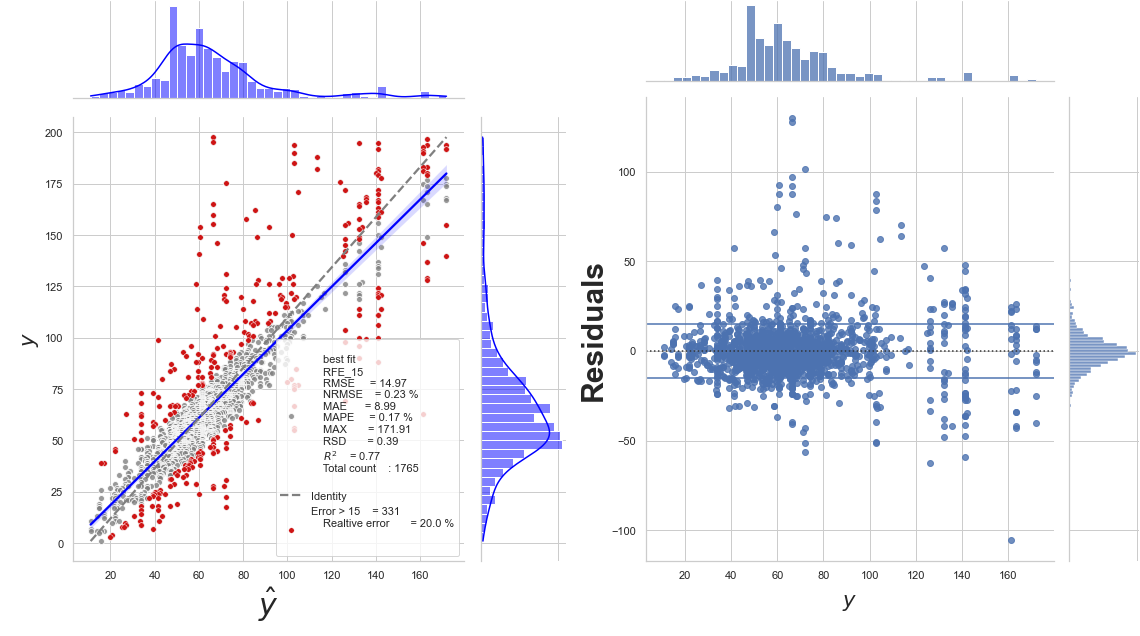

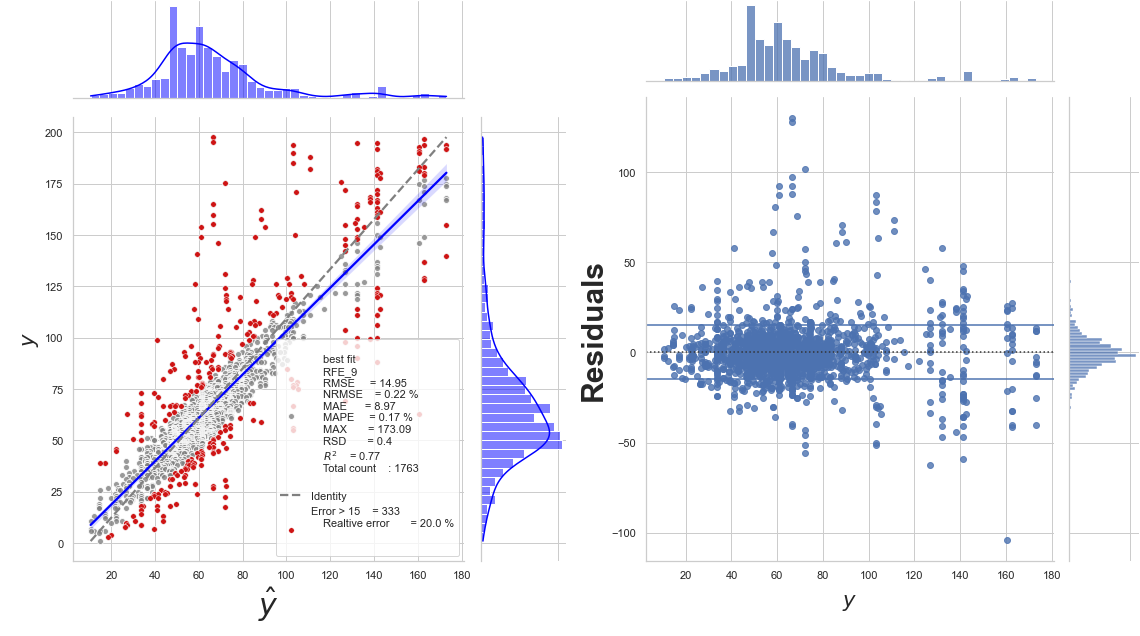

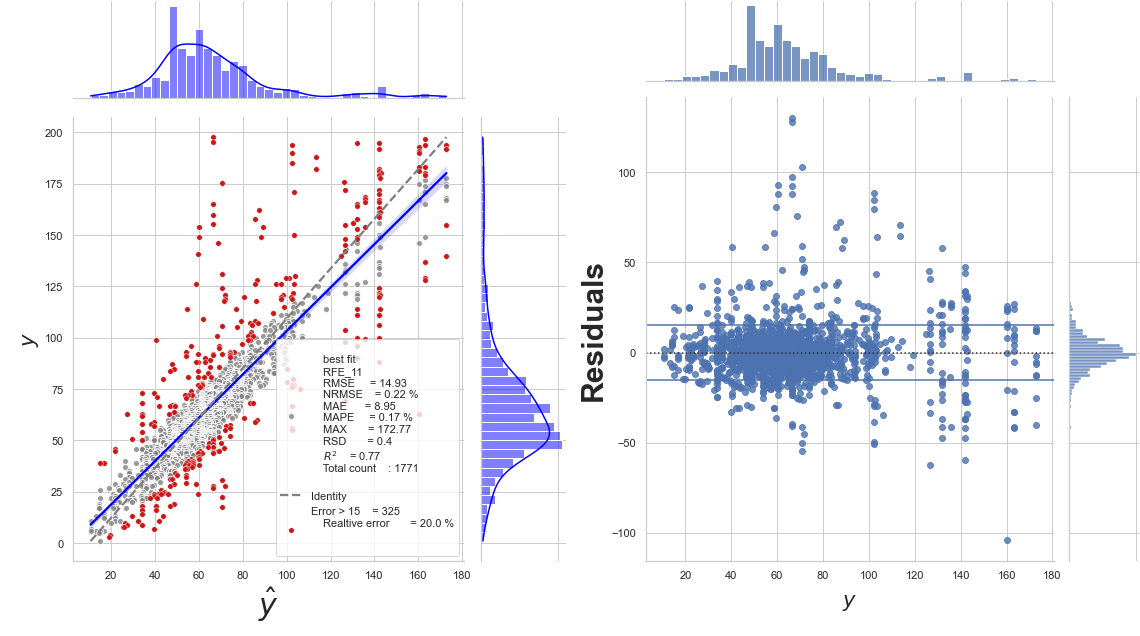

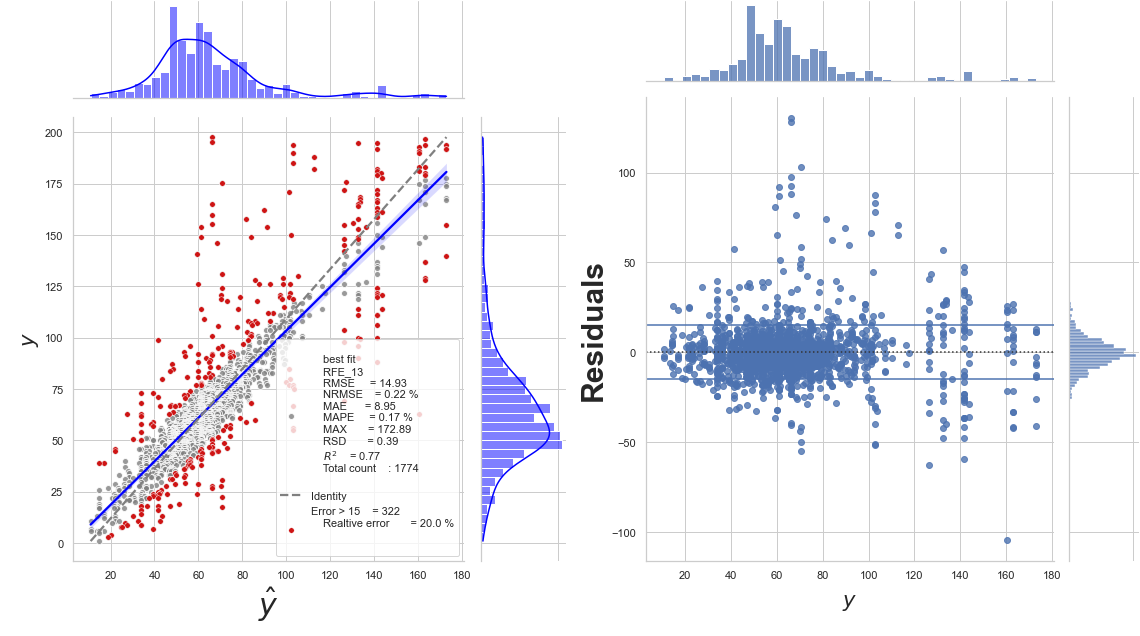

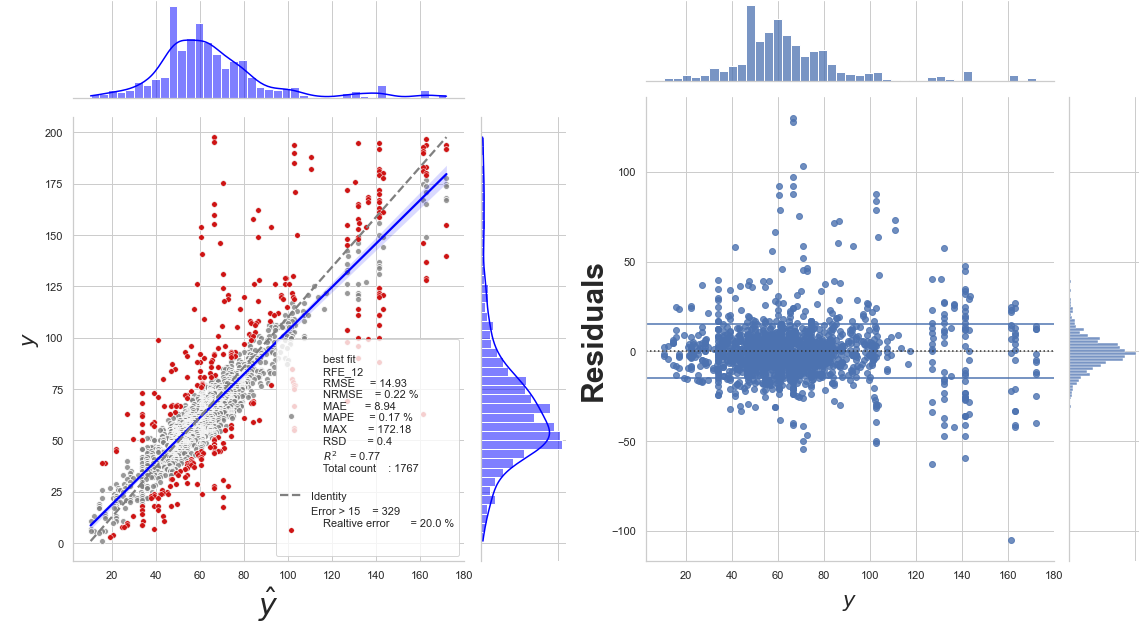

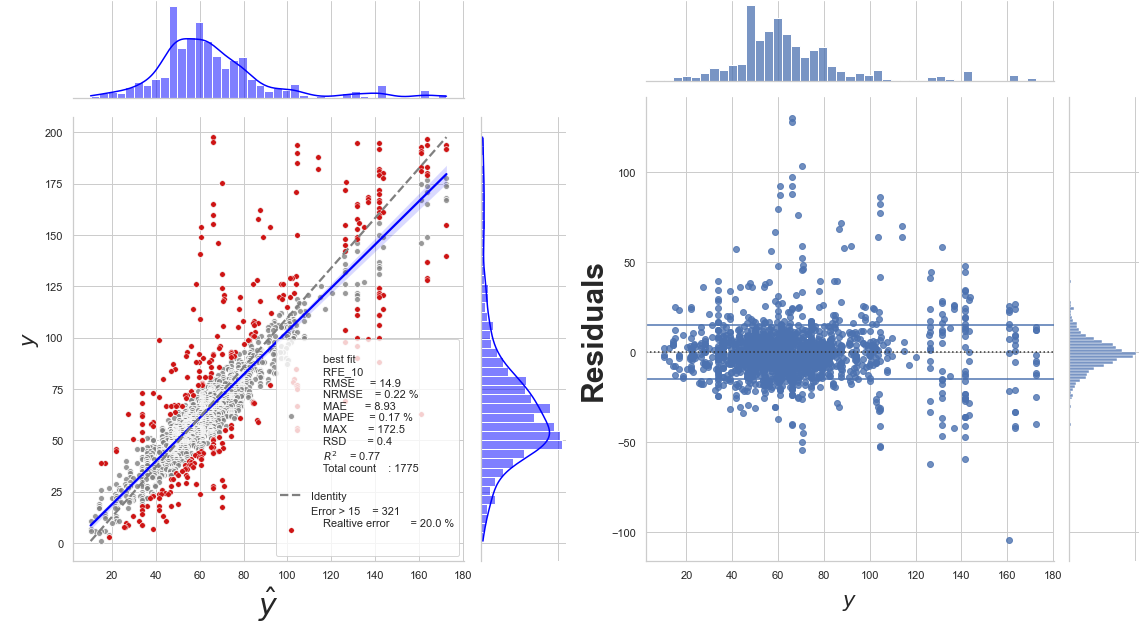

In [18]:
sns.set(style="whitegrid")

# ['RMSE', 'MAE', 'NRMSE','MAPE', 'CD','EV', 'MAX_E', 'MAX', 'Stdev', 'RSD', 'Mean','Median','MedAE', 'MPE', 'Acc']
# False ['CD','EV' ,'MAX', 'MPE']

#len(KPI_Afr_50)
n_models = 10

rfe_range = [col  for col in KPI_Afr_50.columns]

score = 'NRMSE'
columns_W = KPI_Afr_50.loc[score,rfe_range].sort_values(ascending=False).index.tolist()

results_W['y_train_afr'] = y_train_afr

'''shaded area is Size of the confidence interval for the regression estimate. 
This will be drawn using translucent bands around the regression line'''
threshold = 15

for column in columns_W[:n_models]:
    mask = np.abs(results_W['y_train_afr'] - results_W[column]) > threshold
    y_predict = results_W[column]
    
    g0 =sns.jointplot( x=column, y='y_train_afr', data=results_W, kind='reg', size=12,   ratio=4, 
                        marginal_kws={'lw':1, 'color':'blue'}, 
                  scatter_kws={"color": "grey", "edgecolor":"w"}, line_kws={"color": "blue"},
    label=   
    f'''
    best fit
    {column}
    RMSE     = {round(KPI_Afr_50.loc['RMSE', column],2)}
    NRMSE    = {round(KPI_Afr_50.loc['NRMSE', column],2)} %
    MAE      = {round(KPI_Afr_50.loc['MAE', column],2)}
    MAPE     = {round(KPI_Afr_50.loc['MAPE', column],2)} %
    MAX       = {round(KPI_Afr_50.loc['MAX', column],2)}
    RSD       = {round(KPI_Afr_50.loc['RSD', column],2)}
    $R^2$    = {round(KPI_Afr_50.loc['CD', column],2)}
    Total count    : {len(y_predict) - len(y_predict[mask])}   
        ''' )

    sns.regplot([results_W[column].min(), results_W[column].max()], [results_W['y_train_afr'].min(), results_W['y_train_afr'].max()], \
                ci=None, scatter=False, ax= g0.ax_joint, line_kws={"color": "grey", 'ls':'--'} , label = 'Identity')

    sns.scatterplot(results_W[column][mask],results_W['y_train_afr'][mask], color="#ce1414",\
                    s=30,  ax= g0.ax_joint, edgecolor="white",
    label = 
    f'''Error > {threshold}    = {len(y_predict[mask])}
    Realtive error       = {round(len(y_predict[mask]) / len(y_predict), 1)  *100} %

    ''' )

    g0.set_axis_labels( '$\hat{y}$','$_y$', fontsize=30, fontweight='bold')
    g0.fig.suptitle('PREDICTED vs ACTUAL',fontsize=20)

    g0.ax_marg_y.grid('on') 

    #plt.legend()

    plt.tight_layout()
    
    
    #####
    
    g1 = sns.jointplot( x=column, y='y_train_afr', data=results_W, kind="resid", size=12, 
                         line_kws={"color": "blue", 'lowess':True, 'robust':True},     
                         )


    #plot.ax_joint.axvline(x=6)
    g1.ax_joint.axhline(y=threshold )
    g1.ax_joint.axhline(y=-threshold)


    g1.set_axis_labels('$_y$', 'Residuals', fontsize=30, fontweight='bold')
    g1.fig.suptitle(column,fontsize=20)

    g1.ax_marg_y.grid('on') 

    plt.tight_layout()
    
    
    
    
    
    fig = plt.figure(figsize=(16,9))
    fig.set_size_inches(16,9)


    gs = gridspec.GridSpec(1, 2)

    mg0 = SeabornFig2Grid(g0, fig, gs[0])
    mg1 = SeabornFig2Grid(g1, fig, gs[1])

    gs.tight_layout(fig)


    plt.show()


In [19]:

 
kfold = 5

cv = KFold(n_splits=kfold, random_state=None, shuffle=True)

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) 

#scoring = make_scorer(nrmse , greater_is_better=False )
nrmse_score = make_scorer(nrmse , greater_is_better=False)

#scoring = make_scorer(nrmse , greater_is_better=False )
ccc_score = make_scorer(concordance_correlation_coefficient , greater_is_better=True)

scoring = {
    'NRMSE':nrmse_score,
    #'RMSE':'neg_root_mean_squared_error', 
    #'MAE':'neg_mean_absolute_error', 
    #'MAPE':'neg_mean_absolute_percentage_error', 
    'CD':'r2',
    #'EV':'explained_variance'   
    #'CCC': ccc_score,
    
}


results ={}

tuned_params = {item[11:]: best_params[item][0] for item in best_params}
regressor.set_params(**tuned_params)


for key, score in scoring.items():



    # Initialize RFECV object
    feature_selector = RFECV(regressor, cv = cv, step = 1, #n_jobs=-1, 
                             scoring = score, verbose = 1)
    

    # Fit RFECV
    feature_selector .fit(X_train_afr, np.ravel(y_train_afr))
    results[key] = feature_selector

    # Get selected features
    #feature_names = X_train_corr.columns
    #selected_features = feature_names[feature_selector.support_].tolist()

    print(f'terminated {key} {score}\n')
    print('terminated')



Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fittin

Optimal number of features for NRMSE : 12
Optimal number of features for CD : 14


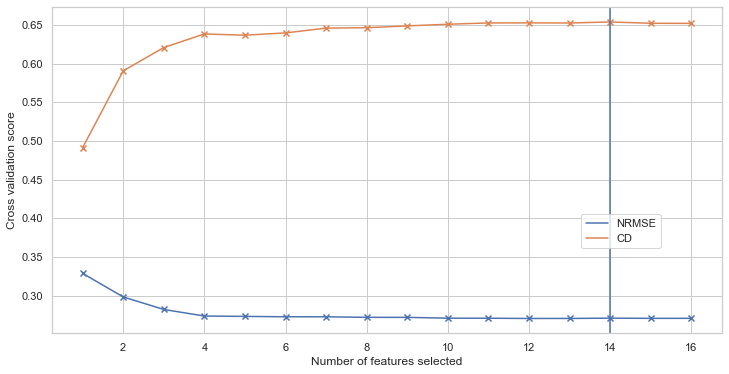

In [20]:
plt.figure(figsize=(12,6))

for key, score in scoring.items():
    #selected_features = feature_names[results[key].support_].tolist()
    # Get Performance Data
    print(f"Optimal number of features for {key} : {results[key].n_features_}")
    results[key].support_rfecv_df = pd.DataFrame(results[key].ranking_,index=X_train_afr.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
    if results[key].grid_scores_.mean(axis=1).min() < 0:
        plt.plot(range(1, len(results[key].grid_scores_) + 1), results[key].grid_scores_.mean(axis=1)*-1, label=key)
        plt.scatter(range(1, len(results[key].grid_scores_) + 1), results[key].grid_scores_.mean(axis=1)*-1, marker='x')

    else:
        plt.plot(range(1, len(results[key].grid_scores_) + 1), results[key].grid_scores_.mean(axis=1), label=key)
        plt.scatter(range(1, len(results[key].grid_scores_) + 1), results[key].grid_scores_.mean(axis=1), marker='x')
        
    
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")
    plt.legend(loc=[.79,0.26])
plt.axvline(results[key].n_features_)



# Kriging

In [21]:

total_features = features_idw

feature_names = train_Afr_50[total_features].columns

regressor = RandomForestRegressor()

tuned_params = {item[11:]: best_params[item][0] for item in best_params}
regressor.set_params(**tuned_params)

scaler = PowerTransformer(method='yeo-johnson',standardize=True)
'''
best_features = 4


feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_4 = feature_names[feature_selector.support_].to_list()

print(selected_features_4)

print('RFE fitting is terminated')

######

best_features = 5


feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_5 = feature_names[feature_selector.support_].to_list()

print(selected_features_5)

print('RFE fitting is terminated')

######
best_features = 6


feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_6 = feature_names[feature_selector.support_].to_list()

print(selected_features_6)

print('RFE fitting is terminated')

######

best_features = 7


feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_7 = feature_names[feature_selector.support_].to_list()

print(selected_features_7)

print('RFE fitting is terminated')

######

best_features = 8


feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_8 = feature_names[feature_selector.support_].to_list()

print(selected_features_8)

print('RFE fitting is terminated')

######

best_features = 9


feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_9 = feature_names[feature_selector.support_].to_list()

print(selected_features_9)

print('RFE fitting is terminated')

######


######

best_features = 10


feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_10 = feature_names[feature_selector.support_].to_list()

print(selected_features_10)

print('RFE fitting is terminated')

######
'''
best_features = 11


feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_11 = feature_names[feature_selector.support_].to_list()

print(selected_features_11)

print('RFE fitting is terminated')

######
'''
best_features = 12



feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_12 = feature_names[feature_selector.support_].to_list()

print(selected_features_12)

print('RFE fitting is terminated')

#####

best_features = 13



feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_13 = feature_names[feature_selector.support_].to_list()

print(selected_features_13)

print('RFE fitting is terminated')

######

best_features = 14




feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_14 = feature_names[feature_selector.support_].to_list()

print(selected_features_14)

print('RFE fitting is terminated')


#####

best_features = 15



feature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train_afr, y_train_afr)

# Get selected features labels
selected_features_15 = feature_names[feature_selector.support_].to_list()

print(selected_features_15)

print('RFE fitting is terminated')


#####

'''


Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
['SI_IDW', 'LAB_IDW', 'MOHO_IDW', 'SV_IDW', 'PV_IDW', 'GEOID_IDW', 'FA_IDW', 'DEM', 'BG_IDW', 'RHO_L_IDW', 'RHO_C_IDW']
RFE fitting is terminated


"\nbest_features = 12\n\n\n\nfeature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)\n\n# Fit RFE\nfeature_selector.fit(X_train_afr, y_train_afr)\n\n# Get selected features labels\nselected_features_12 = feature_names[feature_selector.support_].to_list()\n\nprint(selected_features_12)\n\nprint('RFE fitting is terminated')\n\n#####\n\nbest_features = 13\n\n\n\nfeature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)\n\n# Fit RFE\nfeature_selector.fit(X_train_afr, y_train_afr)\n\n# Get selected features labels\nselected_features_13 = feature_names[feature_selector.support_].to_list()\n\nprint(selected_features_13)\n\nprint('RFE fitting is terminated')\n\n######\n\nbest_features = 14\n\n\n\n\nfeature_selector = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)\n\n# Fit RFE\nfeature_selector.fit(X_train_afr, y_train_afr)\n\n# Get selected features labels\nselected_features_14 = feature_na

In [23]:
pipeline_rk_dict = {}
grids_dict = {}
results_vario = {}
selected_features_dict = {}

 
best_features = [#16, 15, 14, 13,    12, 
                    11,  
                 #10,9 ,8, 7,6, 5,4
                 ]

selected_features = [ #total_features,selected_features_15, 
   # selected_features_14, selected_features_13, 
                       #selected_features_12,
    selected_features_11, 
    #selected_features_10, selected_features_9, selected_features_8 ,
    #selected_features_7, selected_features_6 ,
    #selected_features_5, selected_features_4 
         ]


scoring = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

kfold =10
cv = KFold(n_splits=kfold, random_state=None, shuffle=True)


# 2D Kring param opt
param_dict = {
"variogram_model": [  "gaussian", 
                     #'exponential'
                   ],
 "nlags": np.arange(4,20,2),
 "nlags": [6],
 #'exact_values' : [False, True],
 'n_closest_points' :np.arange(20,40,5),
    'weight' : [False],
    #'pseudo_inv':[True,False],
# "weight": [True, False]
}

label = 'AFR_50' 

for best_feature, selected_feature in zip(best_features ,selected_features) :
    x_Afr_50 = copy.deepcopy(train_Afr_50[coord])
    x_Afr_50.lon = x_Afr_50.lon +180

    x_Afr_50 = x_Afr_50
    y_Afr_50 = train_Afr_50[target]
    p_Afr_50 = train_Afr_50[selected_feature]
    
    print(p_Afr_50.dtypes)

     
    p_train, p_test, x_train, x_test, y_train, y_test = train_test_split(
        p_Afr_50, x_Afr_50, y_Afr_50, test_size=0.3, random_state=42)

    
    regressor_rk = RandomForestRegressor()

    tuned_params = {item[11:]: best_params[item][0] for item in best_params}
    regressor_rk.set_params(**tuned_params)
    
    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[ ("preprocessor", preprocessor),  ("regressor", regressor_rk)]


    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)


    model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)
    
    model_pipeline.fit(p_Afr_50, y_Afr_50 )
    
    #######
    
    y_hat = model_pipeline.predict(p_Afr_50)
    
    #variogram parameters
    print(f'variogram tuning for RFE {best_feature}')
    
    resid_scaler = PowerTransformer(method='yeo-johnson',standardize=True)

    resid= resid_scaler.fit_transform((y_Afr_50 -y_hat).values.reshape(-1,1)).reshape(-1,)

    estimator = GridSearchCV(Krige(coordinates_type='geographic', 
                                   #n_closest_points=15, 
                                   pseudo_inv=True,), param_dict,
                             scoring=scoring,

                         verbose=False, cv=cv,)

    # run the gridsearch
    estimator.fit(x_Afr_50.values, resid )
    
    if hasattr(estimator, "best_score_"):
        print(f"best_score RMSE = {-1*estimator.best_score_}")
        print("best_params = ", estimator.best_params_)
        print("\nCV results::")
    
    
    #######
    

    m_rk = RegressionKriging(regression_model=model_pipeline, 
                          pseudo_inv=True,
                         coordinates_type="geographic",)
    m_rk.krige.set_params(**estimator.best_params_)
    
    #m_rk.fit(p_train, x_train, y_train)
    #m_rk.fit(p_Afr_50, x_Afr_50, y_Afr_50)

    #print(f'train {m_rk.score(p_Afr_50, x_Afr_50, y_Afr_50)}')
    #print(f'test {m_rk.score(p_test, x_test, y_test)}')
    
    m_rk.fit(p_Afr_50, x_Afr_50.values, y_Afr_50)
    
    print(-1*cross_val_score(m_rk.regression_model,p_Afr_50, y_Afr_50, scoring=scoring,
                          cv=cv).mean())

    print(m_rk.krige.get_params())


    
    '''
    vario = Variogram(coordinates=x_train,
          values=y_train,
          use_nugget=True, maxlag= 0.3,
            model = estimator.best_params_['variogram_model'],
          n_lags=int(estimator.best_params_['nlags']))
    vario.plot(hist=True);'''
    
    
    KPI_df = pd.DataFrame()


    sns.set(style="whitegrid", color_codes=True, font_scale = 1)


    #####

   
    ######### save
    nlags = m_rk.krige.get_params()['nlags']
    model_rk= m_rk.krige.get_params()['variogram_model']

    results_vario[f'RK_{model_rk}_{nlags}_RFE_{best_feature}'] = estimator.best_params_
    
    pipeline_rk_dict[f'RK_{model_rk}_{nlags}_RFE_{best_feature}'] = m_rk
    
    grids_dict[f'RK_{model_rk}_{nlags}_RFE_{best_feature}'] =  grids[region].ds[selected_feature].to_array().values
    
    selected_features_dict[f'RK_{model_rk}_{nlags}_RFE_{best_feature}']   = selected_feature

    print(f'RK_{model_rk}_{nlags}_RFE_{best_feature}_{label} fitting is terminated' )




SI_IDW       float64
LAB_IDW      float64
MOHO_IDW     float64
SV_IDW       float64
PV_IDW       float64
GEOID_IDW    float64
FA_IDW       float64
DEM            int64
BG_IDW       float64
RHO_L_IDW    float64
RHO_C_IDW    float64
dtype: object
variogram tuning for RFE 11
best_score RMSE = 1.00795117998567
best_params =  {'n_closest_points': 35, 'nlags': 6, 'variogram_model': 'gaussian', 'weight': False}

CV results::
Finished learning regression model
Finished kriging residuals
18.318970171787676
{'anisotropy_angle': (0.0, 0.0, 0.0), 'anisotropy_scaling': (1.0, 1.0), 'coordinates_type': 'geographic', 'drift_terms': None, 'enable_statistics': False, 'exact_values': True, 'ext_drift_grid': (None, None, None), 'functional_drift': None, 'method': 'ordinary', 'n_closest_points': 35, 'nlags': 6, 'point_drift': None, 'pseudo_inv': True, 'pseudo_inv_type': 'pinv', 'variogram_function': None, 'variogram_model': 'gaussian', 'variogram_parameters': None, 'verbose': False, 'weight': False}
RK_gau

# Varoigram

RK_gaussian_6_RFE_11 : 6 gaussian


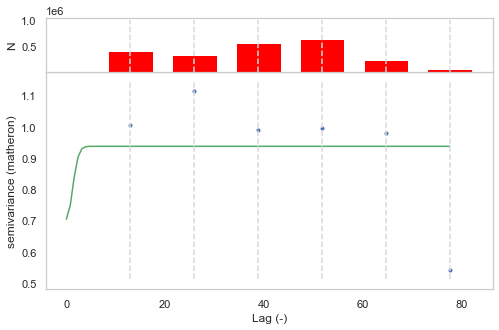

In [24]:
for key, model in results_vario.items():
    print(f"{key} : {model['nlags']} {model['variogram_model']}")
    vario = Variogram(coordinates=x_Afr_50,
          values=resid,
          use_nugget=True, 
                      #maxlag=0.7,
            model = model['variogram_model'],
          n_lags=int(model['nlags']))
    vario.plot(hist=True, )
    

In [25]:
xs = range(grids[region].nx)
ys = range(grids[region].ny)

     

for key, pipeline in pipeline_rk_dict.items():
    pipeline = pipeline_rk_dict[key]
    AFR_50_Q_RFR = np.zeros(grids[region].nn) # predicted HF value
    AFR_50_RL_RFR = np.zeros(grids[region].nn) # predicted HF value
    AFR_50_grid = grids_dict[key]
    #AFR_50_grid  = grids[region].ds[selected_feature].to_array().values
    print(key)
    print(grids_dict[key][0].shape)
    print(pipeline)
    for x in xs:
        print(x,end='\n')
        #print(y,end=',')
        for y in ys:  
            #if np.isfinite(grids[region].ds['LAND'][y,x].values):
            if np.isfinite(sum(AFR_50_grid[:,y,x])):

                AFR_50_Q_RFR_df = pd.DataFrame(AFR_50_grid[:,y,x].reshape(1,-1), 
                                              columns=selected_features_dict[key])
                if 'GLIM' in selected_features_dict[key]:
                    AFR_50_Q_RFR_df['GLIM']  = AFR_50_Q_RFR_df['GLIM'].astype('int').astype('category')
                if 'REG' in selected_features_dict[key]:
                    AFR_50_Q_RFR_df['REG']  = AFR_50_Q_RFR_df['REG'].astype('int').astype('category')


                AFR_50_Q_RFR[y,x] = pipeline.predict(AFR_50_Q_RFR_df,
                    np.asarray([grids[region].lon[y,x]+180,grids[region].lat[y,x]]).reshape(-1,2))

                AFR_50_RL_RFR[y,x] = pipeline.regression_model.predict(AFR_50_Q_RFR_df)

            #else:
               # AFR_50_Q_RFR[y,x] = np.nan
                #AFR_50_RL_RFR[y,x] = np.nan


    print(f'terminated {key}',end='\n')

    grids[region].ds[f'{key}'] = (('Y', 'X'), AFR_50_Q_RFR)
    grids[region].ds[f'{key[3:]}'] = (('Y', 'X'), AFR_50_RL_RFR)

    grids[region].grid_to_raster(grids[region].ds[f'{key}'], save_name= dir_p/'Grids'/'outputs'/'AFR_50'/F'{key}_{rating}.nc')
    grids[region].grid_to_raster(grids[region].ds[f'{key[3:]}'], save_name= dir_p/'Grids'/'outputs'/'AFR_50'/F'RF_{key[3:]}_{rating}.nc')



RK_gaussian_6_RFE_11
(150, 144)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
terminated RK_gaussian_6_RFE_11
